# OCR Pipeline Quality Assessment & Content Drop Analysis

This notebook evaluates a medical OCR pipeline across stages. It measures content changes, text quality, confidence, and medical terminology retention; optionally compares against ground truth; and can summarize multi-engine OCR (MCP) results.

**Note on external tools:** References to Dinglehopper, DavarOCR, MultimodalOCR, and Scribe OCR are informational unless you integrate them explicitly. This notebook does not require or call them by default.

In [1]:
# Imports
import sys, re, json, tempfile
from collections import Counter
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Optional project-local evaluator
sys.path.append('.')
from qa_pipeline_evaluator import QAPipelineEvaluator  # assumes available

# Display defaults
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)

## Configuration

In [2]:
# Paths
RUN_DIR = "../outputs/run_mcp"                  # pipeline run root
PDF_PATH = "../input_pdfs/ET1-Adobe Scan 10 Sept 2025.pdf"
GROUND_TRUTH_DIR = None                          # set if GT available
OUTPUT_DIR = "../outputs/qa_evaluation"

# QA Config
qa_config = {
    "confidence_threshold": 0.7,
    "medical_terms_weight": 0.3,
    "layout_weight": 0.4,
    "content_weight": 0.3,
    "max_content_drop": 0.15,
    "visualization_dpi": 200,
    "medical_terms_file": "../config/medical_terms.yml",
}

print(f"Run: {RUN_DIR}")
print(f"PDF:  {PDF_PATH}")
print(f"Out:  {OUTPUT_DIR}")

run_path = Path(RUN_DIR)
if not run_path.exists():
    print(f"Run directory not found: {RUN_DIR}")
else:
    blocks_dir = run_path / "01_blocks"
    if blocks_dir.exists():
        mcps = list(blocks_dir.glob("*_mcp_*.json"))
        cmp_csv = blocks_dir / "mcp_comparison.csv"
        print(f"MCP JSON files: {len(mcps)}")
        if cmp_csv.exists():
            print(f"MCP comparison CSV: {cmp_csv}")

Run: ../outputs/run_mcp
PDF:  ../input_pdfs/ET1-Adobe Scan 10 Sept 2025.pdf
Out:  ../outputs/qa_evaluation
MCP JSON files: 0


## Patch helpers and robust analytics

In [3]:
# OCR QA PATCH (drop-in)
from pathlib import Path
import re, json, yaml
import numpy as np
import pandas as pd

QA_THRESHOLDS = {
    "page_low_confidence": 0.85,   # problematic if mean_confidence < 0.85
    "page_lowconf_blocks": 3,      # or low_confidence_blocks >= 3
}

MEDICAL_DICT_PATH = "../config/medical_terms.yml"  # optional
STRIP_MARKUP = True

_HTML_TAG_RE = re.compile(r"<[^>]+>")
def strip_markup(text: str) -> str:
    if not STRIP_MARKUP or not isinstance(text, str):
        return text or ""
    return _HTML_TAG_RE.sub(" ", text)

def display_text_sample(text: str, max_len: int = 500) -> str:
    text = text or ""
    return text if len(text) <= max_len else text[:max_len] + "..."

def _load_medical_terms(path: str | Path):
    path = Path(path)
    if not path.exists():
        return set()
    try:
        data = yaml.safe_load(open(path))
        if isinstance(data, dict):
            terms = data.get("terms", [])
        elif isinstance(data, list):
            terms = data
        else:
            terms = []
        return set(t.strip().lower() for t in terms if isinstance(t, str) and t.strip())
    except Exception:
        return set()

_MED_DICT = _load_medical_terms(MEDICAL_DICT_PATH)

_MED_PATTERNS = [
    r"\b\d+\s*mg\b", r"\b\d+\s*ml\b", r"\bmcg\b",
    r"\btablet[s]?\b", r"\bcapsule[s]?\b",
    r"\b\d+\s*times?\s*daily\b", r"\b\d+/\d+\b",
    r"\bdr\.?\s+\w+\b", r"\bpatient\b", r"\bprescription\b", r"\bmedicine\b",
]

def extract_medical_terms(text: str):
    text_clean = (text or "").lower()
    out = []
    if _MED_DICT:
        for t in _MED_DICT:
            if t in text_clean:
                out.append(t)
    for p in _MED_PATTERNS:
        out.extend(re.findall(p, text_clean, re.IGNORECASE))
    return out

def analyze_text_quality(text: str) -> dict:
    t = strip_markup(text or "")
    issues = []
    words = t.split()

    if len(t) > 0 and len(re.findall(r"[^a-zA-Z0-9\s\.,!?;:\-\(\)\/]", t)) > len(t) * 0.1:
        issues.append("High special-character ratio")

    if words:
        wcnt = Counter(words)
        w, c = wcnt.most_common(1)[0]
        if c > len(words) * 0.3:
            issues.append(f"Repetitive token '{w}' ({c}x)")

    long_words = [w for w in words if len(w) > 20]
    if long_words:
        issues.append(f"Very long tokens (e.g., {long_words[:3]})")

    mixed = re.findall(r"\b\w*[0-9]+[a-zA-Z]+\w*|\b\w*[a-zA-Z]+[0-9]+\w*\b", t)
    if len(mixed) > 5:
        issues.append(f"Alpha-numeric noise (e.g., {mixed[:5]})")

    singles = [w for w in words if len(w) == 1 and w.isalpha()]
    if words and len(singles) > len(words) * 0.1:
        issues.append("High single-character token ratio")

    sentences = re.split(r"[.!?]+", t)
    avg_sent_len = sum(len(s.split()) for s in sentences) / max(len(sentences), 1)

    quality = 1.0 - 0.2 * len(issues)
    quality = max(0.1, min(1.0, quality))

    return {
        "issues": issues,
        "quality_score": quality,
        "word_count": len(words),
        "char_count": len(t),
        "avg_sentence_length": avg_sent_len,
        "unique_words": len(set(words)),
    }

def build_stage_summary(df_metrics: pd.DataFrame) -> pd.DataFrame:
    dfm = df_metrics.copy()
    dfm['stage'] = dfm['stage'].astype(str)
    num_cols_all = [
        'total_chars','total_words','total_blocks','mean_confidence',
        'low_confidence_blocks','medical_terms_count',
        'medical_terms_preserved','reading_order_score',
        'chars_added','chars_removed'
    ]
    for c in num_cols_all:
        if c in dfm.columns:
            dfm[c] = pd.to_numeric(dfm[c], errors='coerce')

    agg = {
        'total_chars': ['sum', 'mean'],
        'total_words': ['sum', 'mean'],
        'total_blocks': ['sum', 'mean'],
        'mean_confidence': ['mean'],
    }
    if 'low_confidence_blocks' in dfm.columns:
        agg['low_confidence_blocks'] = ['sum']
    if 'medical_terms_count' in dfm.columns:
        agg['medical_terms_count'] = ['sum']
    if 'medical_terms_preserved' in dfm.columns:
        agg['medical_terms_preserved'] = ['mean']
    if 'reading_order_score' in dfm.columns:
        agg['reading_order_score'] = ['mean']

    stage_summary = dfm.groupby('stage').agg(agg)
    stage_summary.columns = [
        f"{a}_{b}" if b and b != '' else f"{a}"
        for a, b in stage_summary.columns.to_flat_index()
    ]
    try:
        order = sorted(stage_summary.index, key=lambda s: (int(''.join(ch for ch in s if ch.isdigit()) or 0), s))
    except Exception:
        order = sorted(stage_summary.index)
    return stage_summary.loc[order]

def print_content_changes(stage_summary: pd.DataFrame) -> None:
    stages = list(stage_summary.index)
    if len(stages) < 2:
        print("Only one stage present; skipping content-change computation.")
        return
    print("CONTENT CHANGE BETWEEN STAGES")
    for i in range(1, len(stages)):
        prev, cur = stages[i-1], stages[i]
        pv = stage_summary.loc[prev, 'total_chars_sum']
        cv = stage_summary.loc[cur,  'total_chars_sum']
        pv = 0 if pd.isna(pv) else pv
        cv = 0 if pd.isna(cv) else cv
        delta = cv - pv
        pct = (delta / pv * 100) if pv else 0.0
        print(f"{prev} -> {cur}: chars {delta:+,.0f} ({pct:+.1f}%)")

def mark_problematic_pages(df_metrics: pd.DataFrame) -> set:
    pages = set()
    if df_metrics is None or not len(df_metrics):
        return pages
    dfm = df_metrics.copy()
    dfm['stage'] = dfm['stage'].astype(str)
    dfm = dfm.sort_values(['page', 'stage'])
    last_by_page = dfm.groupby('page').tail(1)
    for _, r in last_by_page.iterrows():
        low_conf = (r.get('mean_confidence', 1.0) < QA_THRESHOLDS['page_low_confidence'])
        many_low_blocks = (r.get('low_confidence_blocks', 0) >= QA_THRESHOLDS['page_lowconf_blocks'])
        if low_conf or many_low_blocks:
            pages.add(int(r['page']))
    return pages

def safe_build_dashboard_rows(page_engine_files: dict) -> pd.DataFrame:
    rows = []
    for page_num, engines in page_engine_files.items():
        for engine, file_path in engines.items():
            try:
                blocks = json.load(open(file_path))
                chunk_texts = []
                for b in blocks:
                    if isinstance(b, dict):
                        t = (b.get("text", "") or "").strip()
                        if t:
                            chunk_texts.append(strip_markup(t))
                all_text = " ".join(chunk_texts)
                a = analyze_text_quality(all_text)
                meds = extract_medical_terms(all_text)
                rows.append({
                    "page": page_num, "engine": engine,
                    "text_length": len(all_text),
                    "word_count": len(all_text.split()),
                    "quality_score": a.get("quality_score", 0.0),
                    "issue_count": len(a.get("issues", [])),
                    "medical_terms": len(meds),
                    "avg_sentence_length": a.get("avg_sentence_length", 0.0),
                    "sample_text": display_text_sample(all_text, 120),
                })
            except Exception as e:
                print(f"Warning: failed {engine} on page {page_num}: {e}")
    df = pd.DataFrame(rows)
    if not len(df):
        return df
    return df[df["text_length"] > 0].copy()


## Pipeline structure overview

In [4]:
if run_path.exists():
    stage_dirs = {p.name: p for p in run_path.iterdir()
                  if p.is_dir() and p.name[:2] in {"01", "02", "03", "04", "05"}}
    print(f"Stages: {len(stage_dirs)}")
    total_files = 0
    page_counts = {}
    for s, sp in sorted(stage_dirs.items()):
        jfs = list(sp.glob("*.json"))
        total_files += len(jfs)
        pages = set()
        for f in jfs:
            m = re.search(r'page_(\d+)', f.name)
            if m: pages.add(int(m.group(1)))
        page_counts[s] = len(pages)
        preview = ", ".join(f.name for f in jfs[:3]) + ("" if len(jfs) <= 3 else f" ... (+{len(jfs)-3})")
        print(f"{s}: files={len(jfs)}, pages={len(pages)} | {preview}")
    if page_counts:
        uniq = set(page_counts.values())
        msg = "consistent" if len(uniq) == 1 else f"inconsistent {page_counts}"
        print(f"Page counts: {msg}")
else:
    print(f"Run directory not found: {RUN_DIR}")

Stages: 1
01_blocks: files=21, pages=4 | page_001_ocr_surya_mcp.json, page_003_ocr_easyocr_mcp.json, page_003_blocks.json ... (+18)
Page counts: consistent


## MCP OCR engine comparison (optional)

In [5]:
mcp_comparison_file = run_path / "01_blocks" / "mcp_comparison.csv"
if mcp_comparison_file.exists():
    df_mcp = pd.read_csv(mcp_comparison_file)
    print(f"MCP rows: {len(df_mcp)} | pages: {df_mcp['page'].nunique()} | engines: {', '.join(df_mcp['engine'].unique())}")
    eng = (df_mcp.groupby('engine')
           .agg(total_chars=('total_chars', ['mean','std']),
                total_blocks=('total_blocks', ['mean','std']),
                mean_confidence=('mean_confidence', ['mean','std']),
                processing_time_sec=('processing_time_sec', ['mean','std'])))
    eng.columns = ['_'.join(c).strip() for c in eng.columns]
    display(eng.round(3))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle("MCP OCR Engine Comparison")
    df_mcp.groupby('engine')['total_chars'].mean().plot(kind='bar', ax=axes[0])
    axes[0].set_title('Avg Characters'); axes[0].set_ylabel('chars'); axes[0].tick_params(axis='x', rotation=45)
    df_mcp.groupby('engine')['mean_confidence'].mean().plot(kind='bar', ax=axes[1])
    axes[1].set_title('Avg Confidence'); axes[1].set_ylim(0,1); axes[1].tick_params(axis='x', rotation=45)
    df_mcp.groupby('engine')['processing_time_sec'].mean().plot(kind='bar', ax=axes[2])
    axes[2].set_title('Avg Time (s)'); axes[2].set_ylabel('sec'); axes[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    out_path = Path(OUTPUT_DIR) / "mcp_engine_comparison.png"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {out_path}")
else:
    print("No MCP comparison CSV found; skipping MCP engine comparison.")

No MCP comparison CSV found; skipping MCP engine comparison.


## Text extraction snapshot (first pages)

In [6]:
page_engine_files = {}
if run_path.exists():
    blocks_dir = run_path / "01_blocks"
    if blocks_dir.exists():
        json_files = list(blocks_dir.glob("*.json"))
        for f in json_files:
            m = re.search(r'page_(\d+)_([^.]+)\.json', f.name)
            if m:
                page = int(m.group(1)); engn = m.group(2)
                page_engine_files.setdefault(page, {})[engn] = f
        for page in sorted(page_engine_files)[:3]:
            print(f"PAGE {page}")
            for engn, fp in page_engine_files[page].items():
                try:
                    blocks = json.load(open(fp))
                    texts = [strip_markup((b.get('text','') or '').strip()) for b in blocks if isinstance(b, dict)]
                    texts = [t for t in texts if t]
                    all_text = " ".join(texts)
                    a = analyze_text_quality(all_text)
                    print(f"  {engn}: blocks={len(blocks)} chars={a['char_count']} words={a['word_count']} quality={a['quality_score']:.2f}")
                    if a['issues'][:3]:
                        print(f"    issues: {', '.join(a['issues'][:3])}")
                    print(f"    sample: \"{display_text_sample(all_text, 300)}\"")
                except Exception as e:
                    print(f"  {engn}: error {e}")
    else:
        print("Blocks directory not found.")

PAGE 1
  ocr_surya_mcp: blocks=20 chars=652 words=98 quality=0.80
    issues: Very long tokens (e.g., ['Immunohistochemistry(Manual', '************************************'])
    sample: " Immunohistochemistry  ABHA NO  ABHA ADDRESS  : NA : NA : 08-Sep-2025 11:45 Coll./Study Date CR No : S-1950/25 Lab/Study No. : 339232200297790  Acceptance Date  : 08-Sep-2025 11:45 Age/Sex  Patient Name  : 41 Yr/F : Rizwana Begum Reporting Date : 10-Sep-2025 10:34 Ward/OPD : OPD Sample Type/No :  N ..."
  ocr_easyocr_mcp: blocks=37 chars=560 words=78 quality=0.80
    issues: Very long tokens (e.g., ['(Immunohistochemistry', 'Immunohistochemistry(Manual'])
    sample: "(Immunohistochemistry ABHA NO ABHA ADDRESS NA NA 08-Sep-2025 11.45 Coll /Study Date CR No S-1950/25 Lab/Study No. 339232200297790 Acceptance Date 08-Sep-2025 11.45 AgelSex Patient Name 41 YrIF Begum Rizwana Reporting Date 10-Sep-2025 10.34 Ward/OPD Sample Type/No OPD NA DeptUnit Surg Unit Gen Immuno..."
  blocks: blocks=15 chars=652 word

## Visual text quality dashboard

TEXT QUALITY DASHBOARD


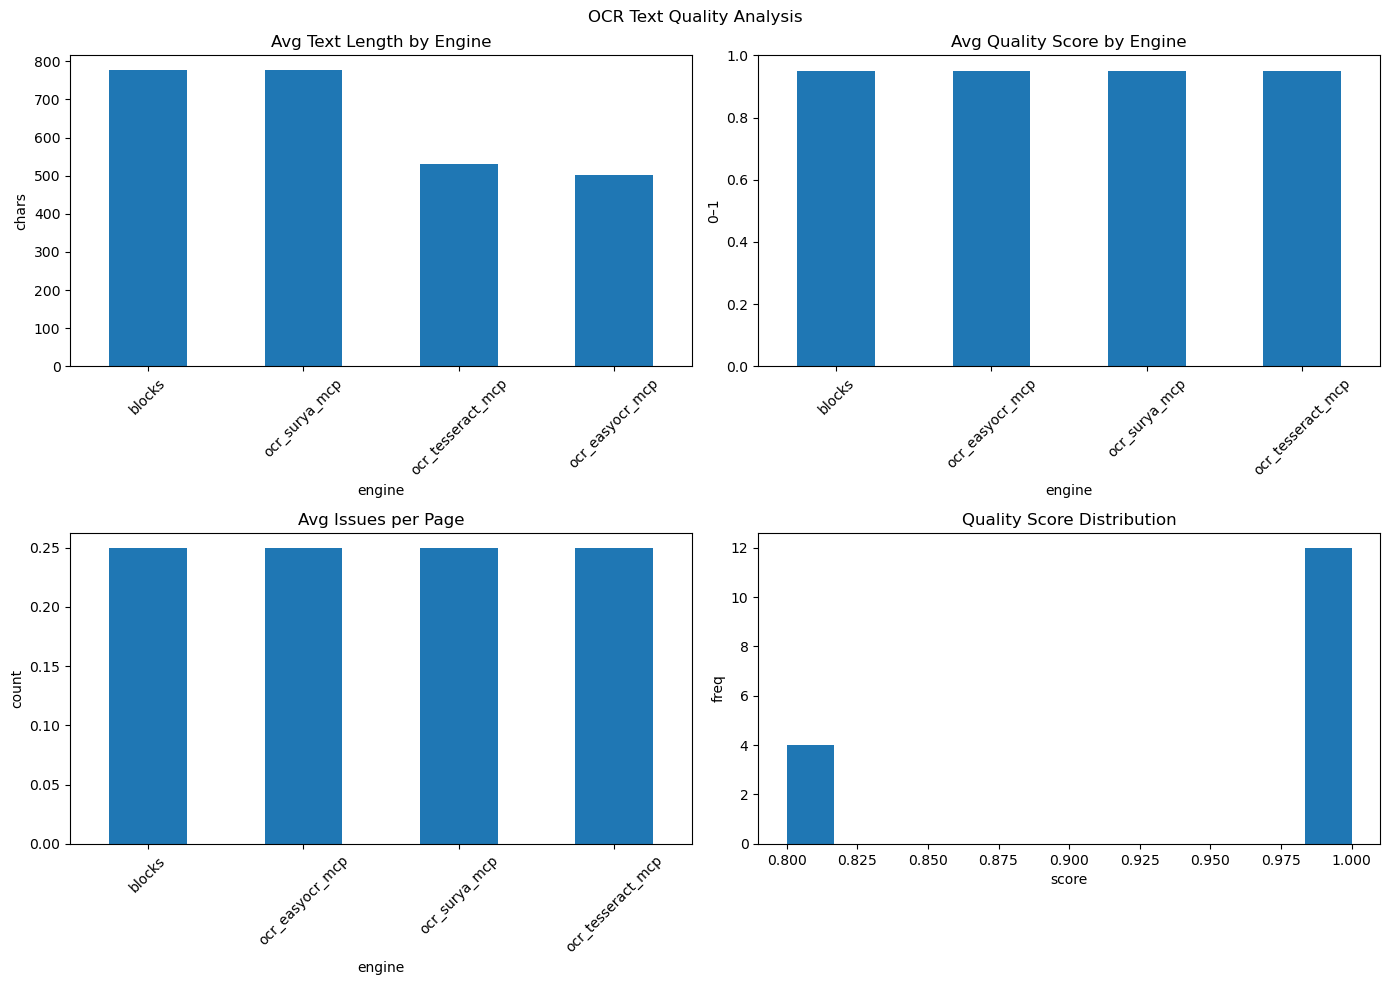

Saved: ../outputs/qa_evaluation/text_quality_dashboard.png

SUMMARY BY ENGINE


,quality_score,text_length,medical_terms,issue_count
engine,,,,
blocks,0.95,776.75,12,0.25
ocr_easyocr_mcp,0.95,500.50,6,0.25
ocr_surya_mcp,0.95,776.75,12,0.25
ocr_tesseract_mcp,0.95,531.25,4,0.25


In [7]:
def build_text_quality_dashboard(blocks_dir, page_engine_files, output_dir, sample_chars=100, show_plots=True):
    blocks_dir = Path(blocks_dir); output_dir = Path(output_dir)
    if not blocks_dir.exists() or not page_engine_files:
        print("No data for dashboard"); return None
    rows = safe_build_dashboard_rows(page_engine_files)
    if rows is None or not len(rows):
        print("No rows for dashboard"); return None
    df = rows
    print("TEXT QUALITY DASHBOARD")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("OCR Text Quality Analysis")
    (df.groupby("engine")["text_length"].mean().sort_values(ascending=False).plot(kind="bar", ax=axes[0,0]))
    axes[0,0].set_title("Avg Text Length by Engine"); axes[0,0].set_ylabel("chars"); axes[0,0].tick_params(axis="x", rotation=45)
    (df.groupby("engine")["quality_score"].mean().sort_values(ascending=False).plot(kind="bar", ax=axes[0,1]))
    axes[0,1].set_title("Avg Quality Score by Engine"); axes[0,1].set_ylabel("0–1"); axes[0,1].set_ylim(0,1); axes[0,1].tick_params(axis="x", rotation=45)
    (df.groupby("engine")["issue_count"].mean().sort_values(ascending=False).plot(kind="bar", ax=axes[1,0]))
    axes[1,0].set_title("Avg Issues per Page"); axes[1,0].set_ylabel("count"); axes[1,0].tick_params(axis="x", rotation=45)
    df["quality_score"].plot(kind="hist", bins=12, ax=axes[1,1])
    axes[1,1].set_title("Quality Score Distribution"); axes[1,1].set_xlabel("score"); axes[1,1].set_ylabel("freq")
    plt.tight_layout()
    output_dir.mkdir(parents=True, exist_ok=True)
    dashboard_path = output_dir / "text_quality_dashboard.png"
    plt.savefig(dashboard_path, dpi=300, bbox_inches="tight")
    if show_plots: plt.show()
    print(f"Saved: {dashboard_path}")
    summary = (df.groupby("engine")
                 .agg(quality_score=("quality_score","mean"),
                      text_length=("text_length","mean"),
                      medical_terms=("medical_terms","sum"),
                      issue_count=("issue_count","mean"))
               ).round(3)
    print("\nSUMMARY BY ENGINE")
    display(summary)
    return {"dataframe": df, "summary": summary, "dashboard_path": str(dashboard_path)}

if 'page_engine_files' in globals() and page_engine_files:
    _dash = build_text_quality_dashboard(blocks_dir, page_engine_files, OUTPUT_DIR)
else:
    print("Skipping dashboard: no page_engine_files available.")

## Run evaluator

In [8]:
print("Initializing evaluator...")
with tempfile.NamedTemporaryFile(mode='w', suffix='.yml', delete=False) as f:
    yaml.dump(qa_config, f)
    config_file = f.name
evaluator = QAPipelineEvaluator(config_path=config_file)
evaluator.output_base = Path(OUTPUT_DIR)
print("Evaluator initialized.")

print("Running evaluation...")
evaluation = evaluator.evaluate_pipeline_run(
    run_dir=RUN_DIR,
    pdf_path=PDF_PATH,
    ground_truth_dir=GROUND_TRUTH_DIR,
)
print("Evaluation complete.")

Initializing evaluator...
Evaluator initialized.
Running evaluation...
Evaluating pipeline run: run_mcp
Found stages: ['01_blocks']
Processing 4 pages: [1, 2, 3, 4]

✓ Evaluation complete for run_mcp
  📊 Detailed metrics: qa_evaluation/metrics/run_mcp_detailed_metrics.csv
  📈 Quality trends: qa_evaluation/reports/run_mcp_quality_trends.png
  📋 Full report: qa_evaluation/reports/run_mcp_evaluation_report.html
  🎯 Overall quality score: 0.660
  📉 Total content drop: 0.0%
  ⚠️  Recommendations:
     • LOW: 9 low-confidence blocks detected. Consider OCR parameter tuning or manual review.
Evaluation complete.


## Overall pipeline performance

In [9]:
print("OVERALL PERFORMANCE")
print(f"Run ID: {evaluation.run_id}")
print(f"PDF: {Path(evaluation.pdf_path).name if evaluation.pdf_path else 'unknown'}")
print(f"Pages: {len(evaluation.pages)}")
print("")
print("Quality")
print(f"Overall Quality Score: {evaluation.quality_score:.3f} (0–1)")
print(f"Total Content Drop:    {evaluation.total_content_drop:.1%}")
print(f"Problematic Pages:     {len(evaluation.problematic_pages)} -> {sorted(evaluation.problematic_pages)}")

OVERALL PERFORMANCE
Run ID: run_mcp
PDF: ET1-Adobe Scan 10 Sept 2025.pdf
Pages: 4

Quality
Overall Quality Score: 0.660 (0–1)
Total Content Drop:    0.0%
Problematic Pages:     0 -> []


## Stage-by-stage analysis

In [10]:
metrics_file = evaluator.metrics_dir / f"{evaluation.run_id}_detailed_metrics.csv"
df_metrics = None
if metrics_file.exists():
    df_metrics = pd.read_csv(metrics_file)
    print(f"Metrics rows: {len(df_metrics)}")
    display(df_metrics.head())
else:
    print(f"Metrics file missing: {metrics_file}")

if df_metrics is not None and len(df_metrics):
    stage_summary = build_stage_summary(df_metrics)
    print("STAGE SUMMARY")
    display(stage_summary.round(3))
    print()
    print_content_changes(stage_summary)
else:
    print("No metrics available to summarize.")

Metrics rows: 4


,page,stage,stage_name,total_chars,total_words,total_blocks,mean_confidence,low_confidence_blocks,medical_terms_count,medical_terms_preserved,reading_order_score,chars_added,chars_removed
0,1,01_blocks,Block Extraction,687,97,20,0.970222,0,1,0.0,1.000000,0,0
1,2,01_blocks,Block Extraction,1252,185,35,0.976491,0,1,0.0,1.000000,0,0
2,3,01_blocks,Block Extraction,113,21,18,0.775630,8,0,0.0,0.944444,0,0
3,4,01_blocks,Block Extraction,589,98,18,0.918851,1,1,0.0,1.000000,0,0


STAGE SUMMARY


,total_chars_sum,total_chars_mean,total_words_sum,total_words_mean,total_blocks_sum,total_blocks_mean,mean_confidence_mean,low_confidence_blocks_sum,medical_terms_count_sum,medical_terms_preserved_mean,reading_order_score_mean
stage,,,,,,,,,,,
01_blocks,2641,660.25,401,100.25,91,22.75,0.91,9,3,0.0,0.986



Only one stage present; skipping content-change computation.


## Quality trend visualizations

Saved: ../outputs/qa_evaluation/reports/run_mcp_custom_analysis.png


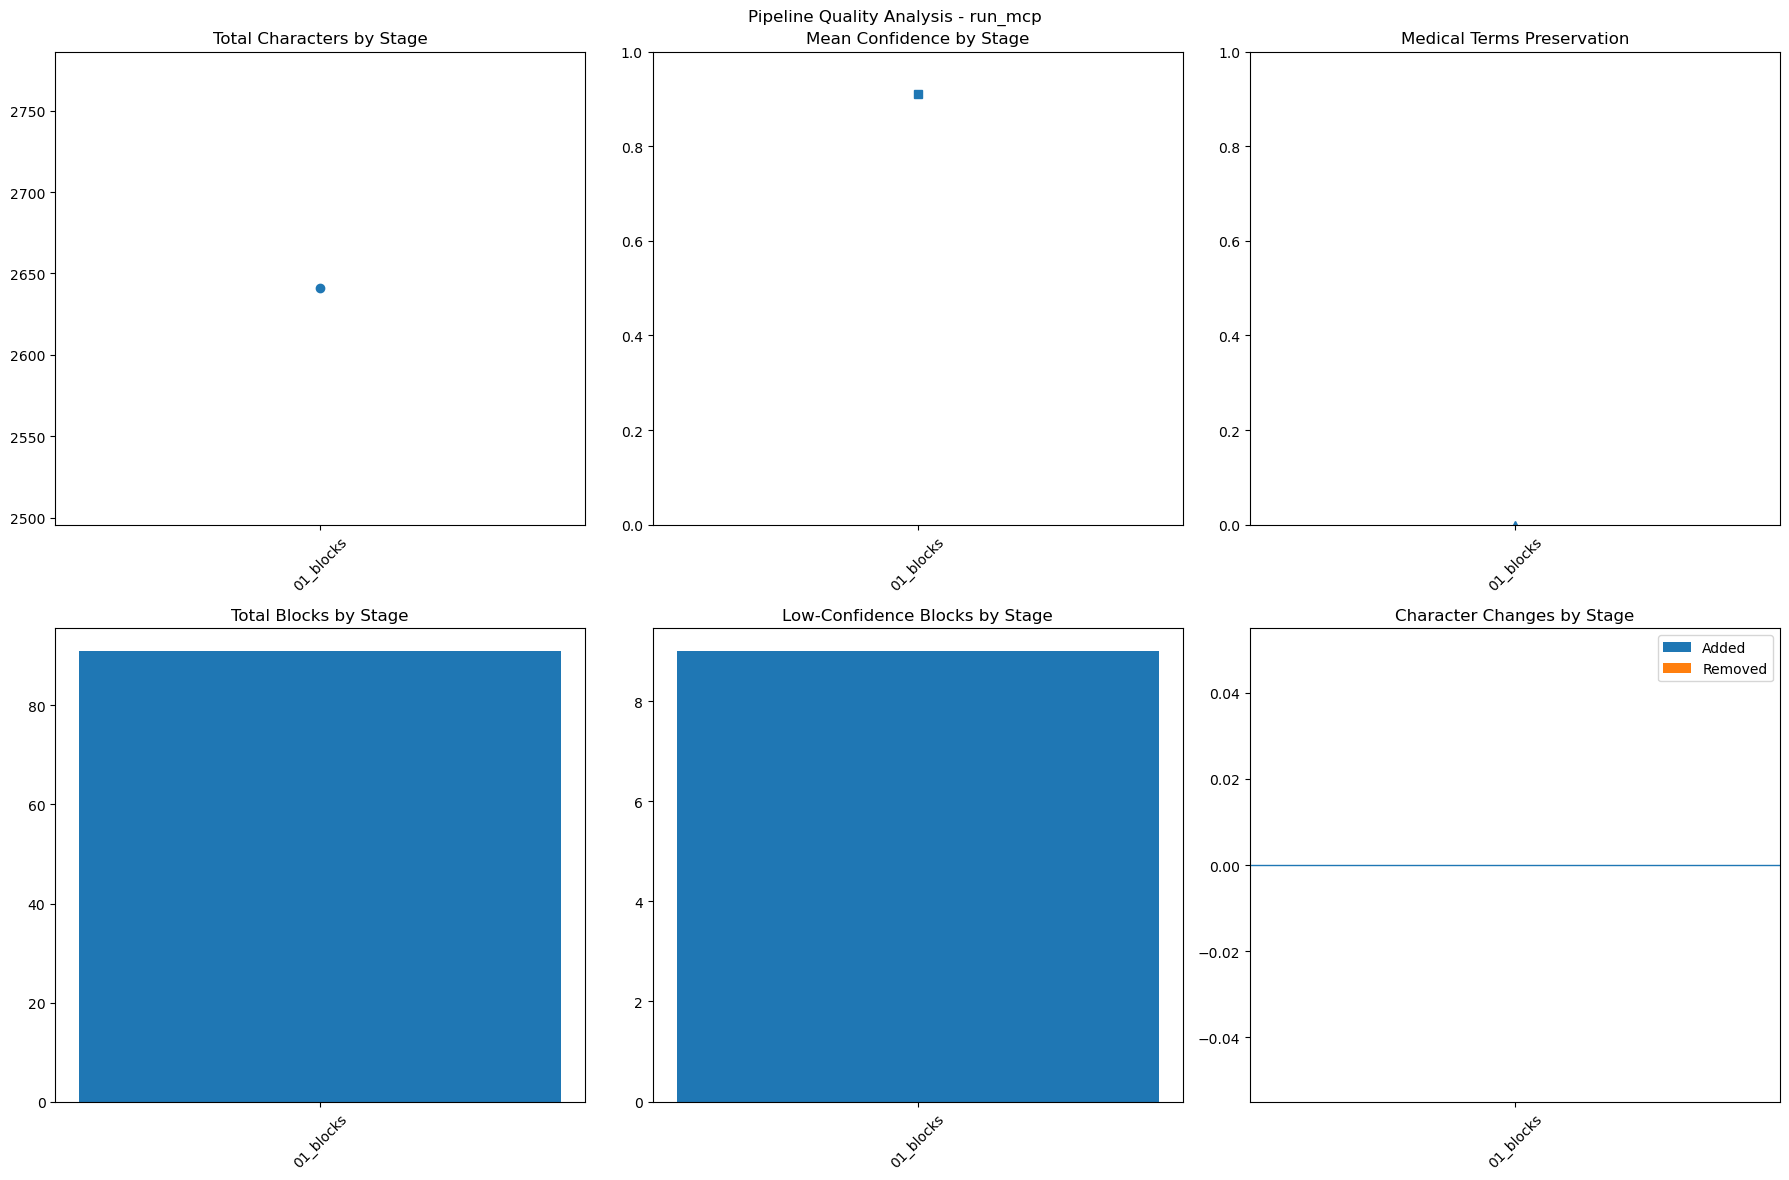

In [11]:
if df_metrics is not None and len(df_metrics):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Pipeline Quality Analysis - {evaluation.run_id}')
    order = sorted(df_metrics['stage'].astype(str).unique())
    x = range(len(order))
    stage_chars = df_metrics.groupby('stage')['total_chars'].sum()
    axes[0,0].plot(x, [stage_chars.get(s, np.nan) for s in order], marker='o', linewidth=2)
    axes[0,0].set_title('Total Characters by Stage'); axes[0,0].set_xticks(x); axes[0,0].set_xticklabels(order, rotation=45)
    stage_conf = df_metrics.groupby('stage')['mean_confidence'].mean()
    axes[0,1].plot(x, [stage_conf.get(s, np.nan) for s in order], marker='s', linewidth=2)
    axes[0,1].set_title('Mean Confidence by Stage'); axes[0,1].set_ylim(0,1); axes[0,1].set_xticks(x); axes[0,1].set_xticklabels(order, rotation=45)
    stage_med = df_metrics.groupby('stage')['medical_terms_preserved'].mean() if 'medical_terms_preserved' in df_metrics.columns else pd.Series()
    if len(stage_med):
        axes[0,2].plot(x, [stage_med.get(s, np.nan) for s in order], marker='^', linewidth=2)
        axes[0,2].set_title('Medical Terms Preservation'); axes[0,2].set_ylim(0,1)
    axes[0,2].set_xticks(x); axes[0,2].set_xticklabels(order, rotation=45)
    stage_blocks = df_metrics.groupby('stage')['total_blocks'].sum()
    axes[1,0].bar(x, [stage_blocks.get(s, 0) for s in order])
    axes[1,0].set_title('Total Blocks by Stage'); axes[1,0].set_xticks(x); axes[1,0].set_xticklabels(order, rotation=45)
    if 'low_confidence_blocks' in df_metrics.columns:
        stage_low = df_metrics.groupby('stage')['low_confidence_blocks'].sum()
        axes[1,1].bar(x, [stage_low.get(s, 0) for s in order])
        axes[1,1].set_title('Low-Confidence Blocks by Stage')
    axes[1,1].set_xticks(x); axes[1,1].set_xticklabels(order, rotation=45)
    if 'chars_added' in df_metrics.columns and 'chars_removed' in df_metrics.columns:
        chars_added = df_metrics.groupby('stage')['chars_added'].sum()
        chars_removed = df_metrics.groupby('stage')['chars_removed'].sum()
        x_pos = np.arange(len(order)); w = 0.35
        axes[1,2].bar(x_pos - w/2, [chars_added.get(s,0) for s in order], width=w, label='Added')
        axes[1,2].bar(x_pos + w/2, [-chars_removed.get(s,0) for s in order], width=w, label='Removed')
        axes[1,2].set_title('Character Changes by Stage'); axes[1,2].axhline(0, linewidth=1)
        axes[1,2].legend()
    axes[1,2].set_xticks(x); axes[1,2].set_xticklabels(order, rotation=45)
    plt.tight_layout()
    plot_path = Path(OUTPUT_DIR) / 'reports' / f"{evaluation.run_id}_custom_analysis.png"
    plot_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {plot_path}")
    plt.show()
else:
    print("No metrics data available for visualization.")

## Per-page summary (final stage)

In [12]:
if df_metrics is not None and len(df_metrics):
    rows = []
    for page in sorted(df_metrics['page'].unique()):
        pg = df_metrics[df_metrics['page'] == page].sort_values('stage')
        if len(pg) == 0:
            continue
        first, last = pg.iloc[0], pg.iloc[-1]
        retention = last['total_chars'] / max(first['total_chars'], 1) if len(pg) > 1 else np.nan
        rows.append({
            "page": page,
            "final_chars": last.get('total_chars', np.nan),
            "final_blocks": last.get('total_blocks', np.nan),
            "final_confidence": last.get('mean_confidence', np.nan),
            "low_conf_blocks": last.get('low_confidence_blocks', np.nan),
            "medical_terms": last.get('medical_terms_count', np.nan),
            "content_retention": retention,
        })
    df_pages = pd.DataFrame(rows).sort_values('content_retention')
    print("PAGE SUMMARY (final stage)")
    display(df_pages.head(20))
    if 'content_retention' in df_pages.columns and df_pages['content_retention'].notna().any():
        print(f"Avg retention:  {df_pages['content_retention'].dropna().mean():.1%}")
    if 'final_confidence' in df_pages.columns and df_pages['final_confidence'].notna().any():
        print(f"Avg confidence: {df_pages['final_confidence'].dropna().mean():.3f}")
else:
    print("No per-page data available.")

PAGE SUMMARY (final stage)


,page,final_chars,final_blocks,final_confidence,low_conf_blocks,medical_terms,content_retention
0,1,687,20,0.970222,0,1,NaN
1,2,1252,35,0.976491,0,1,NaN
2,3,113,18,0.775630,8,0,NaN
3,4,589,18,0.918851,1,1,NaN


Avg confidence: 0.910


## Generated artifacts

In [13]:
out_dir = Path(OUTPUT_DIR)
if out_dir.exists():
    for sub in ['reports','metrics','overlays']:
        p = out_dir / sub
        if p.exists():
            files = list(p.glob('*'))
            print(f"{sub}/ ({len(files)} files)")
            for f in sorted(files)[:10]:
                print(f"  {f.name}  [{f.stat().st_size/1024:.1f} KB]")
            if len(files) > 10:
                print(f"  ... +{len(files)-10} more")
else:
    print(f"Output directory not found: {out_dir}")

reports/ (1 files)
  run_mcp_custom_analysis.png  [242.0 KB]


## Ground truth evaluation (optional)

In [14]:
print("GROUND TRUTH EVALUATION")
gt_pages = []
for page_num, page_eval in evaluation.pages.items():
    if getattr(page_eval, 'ground_truth_file', None):
        gt_pages.append({
            'page': page_num,
            'gt_file': page_eval.ground_truth_file,
            'wer': page_eval.word_error_rate,
            'cer': page_eval.character_error_rate
        })
if gt_pages:
    df_gt = pd.DataFrame(gt_pages)
    print(f"Pages with GT: {len(df_gt)}")
    print(df_gt[['page','wer','cer']].round(3).to_string(index=False))
    avg_wer = df_gt['wer'].mean()
    avg_cer = df_gt['cer'].mean()
    print(f"\nAverages: WER={avg_wer:.3f} CER={avg_cer:.3f}")
    print("Benchmarks: Excellent <5%, Good <15%, Acceptable <25%")
else:
    print("No ground-truth files found. To enable:")
    print(" 1) Create annotated text files per page (page_001.txt, ...)")
    print(" 2) Set GROUND_TRUTH_DIR and re-run.")

GROUND TRUTH EVALUATION
No ground-truth files found. To enable:
 1) Create annotated text files per page (page_001.txt, ...)
 2) Set GROUND_TRUTH_DIR and re-run.


## Action plan

In [15]:
print("ACTION PLAN")
if evaluation.total_content_drop > 0.20:
    print("- High content loss: review DPI/conf thresholds, preprocessing, and page patterns; consider ensemble OCR.")
elif evaluation.total_content_drop > 0.10:
    print("- Moderate content loss: tune thresholds and cleanup rules; review page types; compare MCP engines.")
if evaluation.quality_score < 0.6:
    print("- Quality: add ground truth for 5–10 pages; re-test engines; improve term preservation; review layout/reading order.")
if evaluation.problematic_pages:
    print(f"- Problem pages {sorted(evaluation.problematic_pages)}: manual inspection, page-specific preprocessing, GT annotations, engine trials.")
print("- MCP engines: use comparison results to select primary and fallback; tune per doc type; monitor confidence over time.")
print("- Monitoring: schedule periodic evaluation; set alerts for drops; maintain benchmark sets; version configs.")

ACTION PLAN
- MCP engines: use comparison results to select primary and fallback; tune per doc type; monitor confidence over time.
- Monitoring: schedule periodic evaluation; set alerts for drops; maintain benchmark sets; version configs.


## DSPy Integration Analysis

In [ ]:
# DSPy Enhanced Pipeline Analysis
def analyze_dspy_results(run_dir: str) -> Dict[str, Any]:
    """Analyze results from DSPy-enhanced pipeline stages."""
    run_path = Path(run_dir)
    dspy_analysis = {
        'dspy_stages_found': [],
        'optimization_results': {},
        'confidence_metrics': {},
        'prompt_evolution': {}
    }
    
    # Check for DSPy enhanced stages
    dspy_stage_patterns = [
        "03_llmcleaned_dspy",
        "04_jsonextracted_dspy"
    ]
    
    for pattern in dspy_stage_patterns:
        stage_dir = run_path / pattern
        if stage_dir.exists():
            dspy_analysis['dspy_stages_found'].append(pattern)
            
            # Look for DSPy results
            results_dir = stage_dir / "_dspy_results"
            if results_dir.exists():
                # Load optimization metrics
                stats_files = list(results_dir.glob("*_stats.json"))
                for stats_file in stats_files:
                    try:
                        with open(stats_file) as f:
                            stats = json.load(f)
                        dspy_analysis['optimization_results'][pattern] = stats
                    except Exception as e:
                        print(f"Error loading DSPy stats from {stats_file}: {e}")
                
                # Load confidence metrics
                summary_files = list(results_dir.glob("*_summary.json"))
                for summary_file in summary_files:
                    try:
                        with open(summary_file) as f:
                            summary = json.load(f)
                        dspy_analysis['confidence_metrics'][pattern] = summary
                    except Exception as e:
                        print(f"Error loading DSPy summary from {summary_file}: {e}")
    
    return dspy_analysis

# Check if we have DSPy results in current run
if run_path.exists():
    dspy_results = analyze_dspy_results(RUN_DIR)
    
    if dspy_results['dspy_stages_found']:
        print("DSPy ENHANCED STAGES ANALYSIS")
        print(f"DSPy stages found: {', '.join(dspy_results['dspy_stages_found'])}")
        
        # Display optimization results
        for stage, stats in dspy_results['optimization_results'].items():
            print(f"\n{stage.upper()} OPTIMIZATION:")
            if 'cleaned_blocks' in stats:
                print(f"  Blocks processed: {stats.get('total_blocks', 0)}")
                print(f"  Blocks cleaned: {stats.get('cleaned_blocks', 0)}")
                print(f"  Avg confidence: {stats.get('total_confidence', 0) / max(stats.get('cleaned_blocks', 1), 1):.3f}")
            elif 'successful_extractions' in stats:
                print(f"  Total chunks: {stats.get('total_chunks', 0)}")
                print(f"  Successful extractions: {stats.get('successful_extractions', 0)}")
                print(f"  Valid JSON results: {stats.get('valid_json_count', 0)}")
                success_rate = stats.get('successful_extractions', 0) / max(stats.get('total_chunks', 1), 1)
                validation_rate = stats.get('valid_json_count', 0) / max(stats.get('successful_extractions', 1), 1)
                print(f"  Success rate: {success_rate:.1%}")
                print(f"  Validation rate: {validation_rate:.1%}")
        
        # Performance comparison recommendation
        print("\nDSPy PERFORMANCE RECOMMENDATIONS:")
        print("- Compare DSPy vs traditional pipeline stages using confidence scores")
        print("- Monitor prompt optimization convergence over time")
        print("- Evaluate medical domain accuracy improvements")
        print("- Consider A/B testing DSPy vs traditional approaches")
        
    else:
        print("DSPy INTEGRATION OPPORTUNITY")
        print("No DSPy-enhanced stages found. Consider integrating:")
        print("1. DSPy LLM Cleanup (03_llm_cleanup_dspy.ipynb)")
        print("2. DSPy JSON Extraction (04_json_extraction_dspy.ipynb)")
        print("3. Automatic prompt optimization for medical domain")
        print("4. Confidence-based adaptive processing")
else:
    print("DSPy analysis skipped: run directory not found")

In [16]:
import json, re
from pathlib import Path

# --- Config ---
INPUT_DIR   = Path("../outputs/run_mcp/01_blocks")
OUTPUT_DIR  = Path("../outputs/run_mcp")
ENGINE_TAG  = "ocr_surya_mcp"   # change to: ocr_easyocr_mcp / ocr_tesseract_mcp
OUTPUT_MD   = OUTPUT_DIR / f"{ENGINE_TAG}_text_extraction.md"

def extract_texts_from_json(obj):
    """
    Return a list of text strings from common OCR JSON shapes:
    - [ { "text": "..." }, ... ]
    - { "blocks": [ { "text": "..." }, ... ] }
    - { "pages": [ { "blocks": [ { "text": "..." } ] }, ... ] }
    """
    out = []

    def _pluck(blocks):
        for b in blocks or []:
            if isinstance(b, dict):
                t = (b.get("text") or "").strip()
                if t:
                    out.append(t)

    # list of blocks
    if isinstance(obj, list):
        _pluck(obj)
        return out

    if not isinstance(obj, dict):
        return out

    # dict with 'blocks'
    if "blocks" in obj and isinstance(obj["blocks"], list):
        _pluck(obj["blocks"])

    # dict with 'pages' (each with 'blocks')
    if "pages" in obj and isinstance(obj["pages"], list):
        for p in obj["pages"]:
            if isinstance(p, dict) and isinstance(p.get("blocks"), list):
                _pluck(p["blocks"])

    return out

def build_md_for_engine(input_dir: Path, engine_tag: str, output_md: Path):
    pattern = f"page_*_{engine_tag}.json"
    files = sorted(input_dir.glob(pattern))
    if not files:
        print(f"No files matched pattern: {pattern}")
        return

    pages_md = []
    matched = 0
    extracted = 0

    for jf in files:
        matched += 1
        try:
            if jf.stat().st_size <= 2:  # '[]' or empty
                continue
            with open(jf, "r", encoding="utf-8") as f:
                obj = json.load(f)

            page_match = re.search(r"page_(\d+)_", jf.name)
            page_num = page_match.group(1) if page_match else "?"
            texts = extract_texts_from_json(obj)
            text_blob = "\n".join(texts).strip()

            if text_blob:
                extracted += 1
                pages_md.append(f"## Page {page_num}\n\n{text_blob}\n")
        except Exception as e:
            print(f"Warning: could not process {jf.name}: {e}")

    output_md.parent.mkdir(parents=True, exist_ok=True)
    output_md.write_text("\n---\n".join(pages_md), encoding="utf-8")

    print(f"Matched JSON files: {matched}")
    print(f"Pages with extracted text: {extracted}")
    print(f"Markdown saved: {output_md}")

# Run it for Surya
build_md_for_engine(INPUT_DIR, ENGINE_TAG, OUTPUT_MD)


Matched JSON files: 4
Pages with extracted text: 4
Markdown saved: ../outputs/run_mcp/ocr_surya_mcp_text_extraction.md


In [17]:
# pip install pymupdf
import fitz, json, re
from pathlib import Path

SOURCE_PDF = Path("../input_pdfs/ET1-Adobe Scan 10 Sept 2025.pdf")
INPUT_DIR  = Path("../outputs/run_mcp/01_blocks")
ENGINE_TAG = "ocr_surya_mcp"
PDF_OUT    = Path("../outputs/run_mcp") / f"{ENGINE_TAG}_overlay.pdf"

doc = fitz.open(SOURCE_PDF)
overlay = fitz.open()

for jf in sorted(INPUT_DIR.glob(f"page_*_{ENGINE_TAG}.json")):
    m = re.search(r"page_(\d+)_", jf.name)
    if not m: 
        continue
    page_idx = int(m.group(1)) - 1
    src = doc[page_idx]
    page = overlay.new_page(width=src.rect.width, height=src.rect.height)
    page.show_pdf_page(src.rect, doc, page_idx)

    try:
        data = json.load(open(jf, "r", encoding="utf-8"))
    except Exception:
        continue

    # normalize to list of blocks with bbox + text if present
    blocks = []
    if isinstance(data, list):
        blocks = data
    elif isinstance(data, dict):
        if isinstance(data.get("blocks"), list):
            blocks = data["blocks"]
        elif isinstance(data.get("pages"), list):
            for p in data["pages"]:
                if isinstance(p, dict) and isinstance(p.get("blocks"), list):
                    blocks.extend(p["blocks"])

    for b in blocks:
        if not isinstance(b, dict):
            continue
        t = (b.get("text") or "").strip()
        bbox = b.get("bbox") or b.get("box") or b.get("rect")
        if not t or not bbox or len(bbox) != 4:
            continue
        r = fitz.Rect(*bbox)
        page.draw_rect(r, width=0.6)
        page.insert_text((r.x0, max(0, r.y0 - 2)), t[:100], fontsize=6)

overlay.save(PDF_OUT)
overlay.close()
print(f"Overlay PDF saved: {PDF_OUT}")


Overlay PDF saved: ../outputs/run_mcp/ocr_surya_mcp_overlay.pdf


## Summary
- Stage-wise metrics, quality scoring, and trend plots
- Engine comparison (MCP) and per-page snapshots
- Optional ground-truth evaluation (WER/CER)
- Clear recommendations and action plan